In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import os
from PIL import Image
import glob
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GRU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

csvdata_dir = "/home/stsubokura/FoodRecognition/data/"

folder = ["cucumberinside_csv","cucumberoutside_csv","eggplant_csv","gumi_csv", "kamaboko_csv", "konnyaku_csv", "marshmallow_csv"]

max_dataarraysize = 4423 

csvs = []
label = []
buffer = 50
for index, name in enumerate(folder):
    dir = csvdata_dir + name
    files = glob.glob(dir + "/*.csv")
    for i, file in enumerate(files):
        csv = pd.read_csv(file, sep = '\t', encoding = "shift-jis", error_bad_lines = False, header = None,skiprows=[0])
        
        data_delbefore = np.array(csv, dtype = np.float32).T
        data_deleted = np.delete(data_delbefore, 0, axis = 0) #delete meaningless law
        data_array = data_deleted - data_deleted.mean(axis=0)

        data_array_zero = np.zeros((2, max_dataarraysize))
        
        for i in range(0, int(max_dataarraysize - data_array.shape[1]), buffer):
            data_array_zero = np.zeros((2, max_dataarraysize))
            data_array_zero[:, :data_array.shape[1]] = data_array
            csvs.append(data_array_zero)
            label.append(index)

csvs = np.asarray(csvs)

csvs = csvs
csvs = csvs.astype('float32')


label = np.asarray(label)
label =  tf.keras.utils.to_categorical(label, 7)

csvs_train, csvs_test, label_train, label_test = train_test_split(csvs, label, test_size=0.1, random_state=111)

print(csvs_train.shape)
print(csvs_train.shape)


(10664, 2, 4423)
(10664, 2, 4423)


In [5]:
np.set_printoptions(threshold=np.inf)
print(csvs_train.shape[1:])

(2, 4423)


In [2]:
# GRUを構築
hid_dim = 16
epochs = 100
#複数のGPUを用いる

with tf.distribute.MirroredStrategy().scope():
    model = Sequential()
    model.add(GRU(hid_dim, input_shape=csvs_train.shape[1:], activation = 'relu')) # input_shape=(系列長T, x_tの次元), output_shape=(units(=hid_dim),)
    model.add(Dense(label_train.shape[1], activation='softmax'))
    model.summary()

# コンパイル
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# # 実行。出力はなしで設定(verbose=0)。
# history = model.fit(dataarrays_train, label_train, batch_size=, epochs=100, validation_data=(dataarrays_test, label_test))

# 実行。出力はなしで設定(verbose=0)。
history = model.fit(csvs_train, label_train, batch_size=256, epochs=epochs, validation_data=(csvs_test, label_test))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                213168    
_________________________________________________________________
dense (Dense)                (None, 7)                 119       
Total params: 213,287
Trainable params: 213,287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job

42/42 [==============================] - 1s 26ms/step - loss: 0.0063 - accuracy: 0.9943 - val_loss: 0.0060 - val_accuracy: 0.9958
Epoch 40/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0093 - accuracy: 0.9893 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 41/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0053 - accuracy: 0.9954 - val_loss: 0.0068 - val_accuracy: 0.9865
Epoch 42/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0051 - accuracy: 0.9949 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 43/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0040 - accuracy: 0.9975 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 44/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0052 - accuracy: 0.9956 - val_loss: 0.0066 - val_accuracy: 0.9823
Epoch 45/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0076 - accuracy: 0.9917 - val_loss: 0.0080 - val_accuracy: 0.9916
Epoch 46/100

42/42 [==============================] - 1s 24ms/step - loss: 0.0052 - accuracy: 0.9955 - val_loss: 0.0112 - val_accuracy: 0.9823
Epoch 97/100
42/42 [==============================] - 1s 24ms/step - loss: 0.0048 - accuracy: 0.9963 - val_loss: 0.0063 - val_accuracy: 0.9916
Epoch 98/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0050 - accuracy: 0.9952 - val_loss: 0.0081 - val_accuracy: 0.9916
Epoch 99/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0064 - accuracy: 0.9943 - val_loss: 0.0200 - val_accuracy: 0.9797
Epoch 100/100
42/42 [==============================] - 1s 24ms/step - loss: 0.0444 - accuracy: 0.9452 - val_loss: 0.0291 - val_accuracy: 0.9713


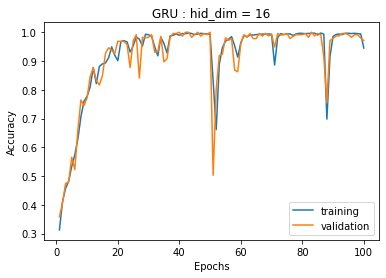

In [3]:

plt.title('GRU : hid_dim = ' + str(hid_dim))
plt.plot(range(1, epochs+1), history.history['accuracy'], label="training")
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
